In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

c:\Users\andre\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\andre\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\andre\anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    return rect

In [3]:
def four_point_transform(image, pts):
    # Assign the points to the corresponding variables
    (tl, tr, bl, br) = [np.array(point, dtype="float32") for point in pts]

    # Compute the width and height of the new image
    width_A = np.linalg.norm(br - bl)
    width_B = np.linalg.norm(tr - tl)
    width = max(int(width_A), int(width_B))

    height_A = np.linalg.norm(tr - tl)
    height_B = np.linalg.norm(br - bl)
    height = max(int(height_A), int(height_B))

    # Define the coordinates of the new image
    dst = np.array([
        [0, 0],
        [width - 1, 0],
        [0, height - 1],
        [width - 1, height - 1]
    ], dtype="float32")

    # Compute the homography matrix and perform the transformation
    M = cv2.getPerspectiveTransform(np.array([tl, tr, bl, br], dtype="float32"), dst)
    warped = cv2.warpPerspective(image, M, (width, height))

    return warped

In [27]:
def four_point_transform_full(image, pts):
    # Convert the points to numpy arrays
    (tl, tr, bl, br) = [np.array(point, dtype="float32") for point in pts]

    # Compute the width and height of the new image
    width_A = np.linalg.norm(br - bl)
    width_B = np.linalg.norm(tr - tl)
    width = max(int(width_A), int(width_B))

    height_A = np.linalg.norm(tr - tl)
    height_B = np.linalg.norm(br - bl)
    height = max(int(height_A), int(height_B))

    # Define the coordinates of the new image
    dst = np.array([
        [0, 0],
        [width, 0],
        [0, height],
        [width, height]
    ], dtype="float32")

    # Compute the homography matrix and perform the transformation
    M = cv2.findHomography(np.array([tl, tr, bl, br], dtype="float32"), dst)[0]
    h, w = image.shape[:2]
    warped = cv2.warpPerspective(image, M, (w, h))

    return warped


In [5]:
def draw_corner_points(image, points, radius=5, color=(0, 255, 0), thickness=-1):
    image_with_points = image.copy()
    for point in points:
        cv2.circle(image_with_points, tuple(point.astype(int)), radius, color, thickness)

    return image_with_points

In [6]:
def draw_four_points(image, points, color=(0, 255, 0), radius=5, thickness=-1):
    # Make a copy of the input image to avoid modifying the original
    modified_image = image.copy()

    # Draw points on the image
    for point in points:
        x, y = point
        cv2.circle(modified_image, (x, y), radius, color, thickness)

    return modified_image

In [39]:
def normalize_vector(v):
    return v / np.linalg.norm(v)

def expand_rectangle(points, n):
    # Calculate the center of the original points
    center = np.mean(points, axis=0)

    # Calculate two adjacent side vectors of the rectangle
    v1 = np.array(points[1]) - np.array(points[0])
    v2 = np.array(points[2]) - np.array(points[0])

    # Normalize and scale the side vectors
    v1_new = normalize_vector(v1) * np.linalg.norm(v1) * n
    v2_new = normalize_vector(v2) * np.linalg.norm(v2) * n

    # Calculate the new corner points using the center and new side vectors
    new_points = [
        center - v1_new / 2 - v2_new / 2,
        center + v1_new / 2 - v2_new / 2,
        center - v1_new / 2 + v2_new / 2,
        center + v1_new / 2 + v2_new / 2,
    ]

    # Convert the new_points to integers
    new_points = [(int(x), int(y)) for x, y in new_points]

    return new_points

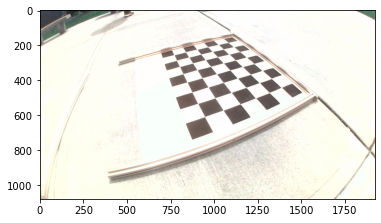

In [7]:
# Load the image
image = cv2.imread('../img_training_data/left_camera_image_checkerboard.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(image)

[(1046, 201), (1445, 515), (639, 293), (1038, 607)]


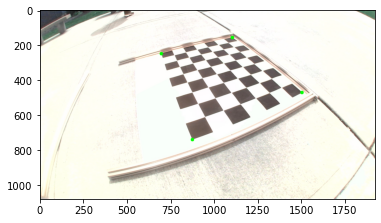

In [43]:
points = [(1102,157), (1501, 471), (695, 249), (873, 740)]
new_points = expand_rectangle(points, 1)
print(new_points)
new_image = draw_four_points(image,points,radius=10)
plt.imshow(new_image)

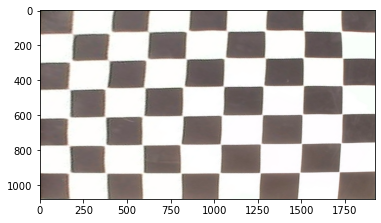

In [45]:
warped = four_point_transform(image, points)
plt.imshow(warped)

In [14]:
def remove_fisheye(image, k1=-0.3, k2=0.1, p1=0, p2=0):
    h, w = image.shape[:2]
    f = max(h, w)
    K = np.array([[f, 0, w/2], [0, f, h/2], [0, 0, 1]], dtype=np.float32)
    dist_coef = np.array([k1, k2, p1, p2], dtype=np.float32)

    new_K, _ = cv2.getOptimalNewCameraMatrix(K, dist_coef, (w, h), 1, (w, h))

    mapx, mapy = cv2.initUndistortRectifyMap(K, dist_coef, None, new_K, (w, h), 5)
    undistorted = cv2.remap(image, mapx, mapy, cv2.INTER_LINEAR)

    return undistorted

In [19]:
def trim_image(image, x):
    h, w = image.shape[:2]
    trimmed_image = image[x:h - x, x:w - x]
    return trimmed_image

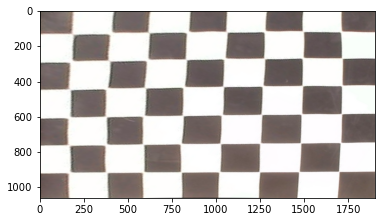

In [46]:
undistorted = remove_fisheye(warped, -0.05, -0.05)
plt.imshow(trim_image(undistorted, 10))

In [13]:
# Detect checkerboard corners
pattern_size = (9,7)  # Adjust this based on the number of internal corners in your checkerboard

found, corners = cv2.findChessboardCornersSB(warped, pattern_size, flags=cv2.CALIB_CB_EXHAUSTIVE)
found


False

In [ ]:
if found:
    cv2.drawChessboardCorners(image, (3,3), corners, found)

    warped = four_point_transform(gray, corners.reshape(4,2))
    cv2.imshow("Original", image)
    cv2.imshow("Top View", warped)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
else:
    print("Checkerboard pattern not found. Please try again with a different image.")

In [ ]:
corner_points = np.array([corners[0, 0], corners[pattern_size[0]-1, 0], corners[-1, 0], corners[-pattern_size[0], 0]])
warped = four_point_transform(gray, corner_points)

In [ ]:
corners.reshape(-1,2)

In [ ]:
image_with_points = draw_corner_points(image, corners.reshape(-1,2))
